# Classifying Subreddit Posts <br>

_**Author:** Bala Krishnamoorthy_ <br>
_**Date**: December 2018_

### Overview <br>

**Goal:** Build a model that can classify reddit posts into the subreddit they belong to. <br>

**Note:** Throughout this workbook, you'll find my comments/insights on the workflow in _italics_ and `#comments`. <br>

## Contents

- [Methodology](#Methodology)
- [Import Libraries](#Import-Libraries)
- [Data Gathering](#Data-Gathering)
- [Import Gathered Data](#Import-Gathered-Data)
- [Data Cleaning](#Data-Cleaning)
- [Modelling with NLP: r/science vs r/technology](#Modelling-with-NLP:-r/science-vs-r/technology)
- [Model Performance with Other Subreddits](#Model-Performance-with-Other-Subreddits)
- [Visualizing Results](#Visualizing-Results)

### Methodology <br>

To do this, I will build and compare four classifiers: **Logistic Regression**, **RandomForest** , **Naive-Bayes** and **Support Vector Classifier**. Each classifier will rely on natural language processing (NLP) on the text within each post to better understand the characteristics (and ideally context) of the post. By doing so, the classifier will learn which post belongs in which subreddit. 

Here is an overview of the steps taken to build each classifier: <br>

Steps common to both classifiers: 
- Pull posts from subreddits being examined using Reddit's API
- Clean gathered data to extract post content (text), and any other potential identifying characteristics within each post. <br>
- NLP:
    - Vectorize data using CountVectorizer or TF-IDF
- Modelling
- Evaluate Model (initial)
- Changes + Hyperparameter tuning: GridSearch, others?
- Evaluate Model (final)


#### Import Libraries

In [53]:
# Data Manipulation
import numpy as np
import pandas as pd
import regex as re

# Machine Learning: sklearn
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# Machine Learning: nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

# JSON Manipultion / API Access
import json
import requests
import time
import datetime
from bs4 import BeautifulSoup

# Time 
import time

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # For dark themed j-notebooks

# Other
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Data Gathering

_The code below accesses Reddit's API and pulls subreddit posts from the specified subreddits within the `subreddits` list object. <br>
Extracted posts are output to a csv file._

In [2]:
# # Pulling posts from subreddits

# ## Set timer
# t0 = time.time()

# # Define parameters used in for-loop below
# # Subreddits: 'technology/', 'fitness/', 'sports/', 'showerthoughts/', 'mildlyinteresting/'
# # 'controversial', 'top', 'rising'
# subreddits = ['science/', 'technology/', 'fitness/', 'sports/', 'showerthoughts/', 
#               'mildlyinteresting/']
# filters = ['new'] 
# # The most number of subreddit posts are available in the 'new' filter. The default subreddit url
# # brings up the 'hot' filter within the subreddit. As part of this analysis, I found that reddit
# # splits all 'new' posts into 'hot', 'top', 'controversial' and 'rising'.
# for subreddit in subreddits:
#     posts = []
#     print('Pulling posts from:', subreddit, '...')
#     print()
#     for filter in filters: 
#         print()
#         print('Pulling filter:', filter, '...')
#         print()
#         url = 'https://www.reddit.com/r/' + subreddit + filter + '.json'
#         after = None
#         agent = {'User-agent': 'red_bk'}
#         num_requests = 100 # Number of times to request posts from reddit's API
#         for i in range(num_requests):
#             if i % 10 == 0:
#                 print('Requests made:', i)
#             if after == None:
#                 params = {} # this dict represents the unique tag that tells us the last post pulled
#             else:
#                 params = {'after': after}
#             res = requests.get(url, headers=agent, params=params)
#             if res.status_code == 200:
#                 the_json = res.json()
#                 posts.extend(the_json['data']['children'])
#                 after = the_json['data']['after']
#                 if i % 5 == 0:
#                     agent['User-agent'] = 'red_bk' + str(i)
#             else:
#                 print('Error:', status_code)
#                 break
#         # Convert subreddit list of dictionaries to posts
#     df = pd.DataFrame(posts)
#     df.to_csv('./data/' + subreddit[:-1] + '_' + time.strftime('%Y-%m-%d-%I%p'), index=False)
#     time.sleep(1)

# time_elapsed_secs = time.time() - t0 # time elapsed in seconds
# print()
# print('Num of Posts Collected (last subreddit):', len(posts))
# print('Time Elapsed:', datetime.timedelta(seconds=time_elapsed_secs))
# print('Code ended at:', time.strftime('%Y-%m-%d-%I%p:%Mmins'))

### Import Gathered Data

_Posts in csv format are extracted as a pandas dataframe and cleaned for further analysis._

In [3]:
shower_df = pd.read_csv('./data/showerthoughts_2018-12-17-03PM')
science_df = pd.read_csv('./data/science_2018-12-17-03PM')
tech_df = pd.read_csv('./data/technology_2018-12-17-03PM')
fit_df = pd.read_csv('./data/fitness_2018-12-17-03PM')
sports_df = pd.read_csv('./data/sports_2018-12-17-03PM')
mild_df = pd.read_csv('./data/mildlyinteresting_2018-12-17-03PM')

In [4]:
list_of_dfs = [science_df, tech_df, fit_df, sports_df, mild_df, shower_df]

In [5]:
# Convert dictionaries stored as strings back to dictionaries
for df in list_of_dfs:
    df['data'] = df['data'].map(lambda x: eval(x))

In [6]:
# Check type of dict entry
# type(science_df['data'][0])

In [7]:
# Num of unique posts in each subreddit (using 'name' for each post as an identifier)

for df in list_of_dfs:
    sr_name = df['data'][0]['subreddit']
    df['post_name'] = df['data'].map(lambda x: x['name'])
    print(sr_name, 'Num of Unique Posts:', len(set(df['post_name'])))

science Num of Unique Posts: 870
technology Num of Unique Posts: 536
Fitness Num of Unique Posts: 914
sports Num of Unique Posts: 498
mildlyinteresting Num of Unique Posts: 998
Showerthoughts Num of Unique Posts: 998


In [8]:
science_df.head()

,data,kind,post_name
0,"{'approved_at_utc': None, 'subreddit': 'scienc...",t3,t3_a74sy0
1,"{'approved_at_utc': None, 'subreddit': 'scienc...",t3,t3_a74lvx
2,"{'approved_at_utc': None, 'subreddit': 'scienc...",t3,t3_a74jhp
3,"{'approved_at_utc': None, 'subreddit': 'scienc...",t3,t3_a74bl1
4,"{'approved_at_utc': None, 'subreddit': 'scienc...",t3,t3_a74aro


In [9]:
# There are duplicate posts within each df (reddit provides duplicates once all the "new" posts
# according to reddit have been provided.)
for df in list_of_dfs:
    df.drop_duplicates(subset='post_name', inplace=True)

In [10]:
# Check to make sure duplicates were dropped correctly
for df in list_of_dfs:
    sr_name = df['data'][0]['subreddit']
    print(sr_name, 'Rows:', df.shape[0])

science Rows: 870
technology Rows: 536
Fitness Rows: 914
sports Rows: 498
mildlyinteresting Rows: 998
Showerthoughts Rows: 998


_Subreddits to compare: r/science and r/technology_ <br>
- _Both are relatively similar, however, r/science tends to focus on academic research while r/technology appears to be more news-oriented._

In [11]:
# Combine science and technology dfs
df_st = pd.concat([science_df, tech_df], axis=0)

In [12]:
# Reset index range after combining dfs 
df_st.reset_index(inplace=True)

In [13]:
df_st.index # Check index range

RangeIndex(start=0, stop=1406, step=1)

### Data Cleaning

_Let's begin by cleaning posts from the r/science and r/technology subreddits. These subreddits are relatively similar in terms of content._

In [14]:
# Separate the dictionary entries for each post into individual columns 

# Combined df

dict_keys = sorted(df_st['data'][0].keys())

In [15]:
# Check number of keys (i.e. data fields) for each post
(df_st['data'].map(lambda x: len(x.keys()))).value_counts(normalize=True)

# Most posts have a similar number of keys. The keys missing in certain posts are unlikely to
# be significant features for this analysis

96    0.540541
92    0.369844
94    0.086771
99    0.000711
97    0.000711
93    0.000711
90    0.000711
Name: data, dtype: float64

In [16]:
# List of data fields within each post
print(dict_keys)

['approved_at_utc', 'approved_by', 'archived', 'author', 'author_flair_background_color', 'author_flair_css_class', 'author_flair_richtext', 'author_flair_template_id', 'author_flair_text', 'author_flair_text_color', 'author_flair_type', 'author_fullname', 'author_patreon_flair', 'banned_at_utc', 'banned_by', 'can_gild', 'can_mod_post', 'category', 'clicked', 'content_categories', 'contest_mode', 'created', 'created_utc', 'distinguished', 'domain', 'downs', 'edited', 'gilded', 'gildings', 'hidden', 'hide_score', 'id', 'is_crosspostable', 'is_meta', 'is_original_content', 'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 'is_video', 'likes', 'link_flair_background_color', 'link_flair_css_class', 'link_flair_richtext', 'link_flair_template_id', 'link_flair_text', 'link_flair_text_color', 'link_flair_type', 'locked', 'media', 'media_embed', 'media_only', 'mod_note', 'mod_reason_by', 'mod_reason_title', 'mod_reports', 'name', 'no_follow', 'num_comments', 'num_crossposts', 'num_rep

Inspecting the data fields above shows that many of them contain data for admin/formatting purposes, as opposed to information on the content of the post (e.g. "author_flair_background_color", "is_robot_indexable", etc.) that might allude to which subreddit it belongs to. Thus, I will select a subset of these data fields to examine in further detail.

In [17]:
# Selected data fields

post_fields = ['approved_by', 'author', 'category', 'content_categories', 'created', 'domain', 
              'likes', 'media', 'name', 'num_comments', 'num_crossposts', 'num_reports','selftext',
               'subreddit', 'title', 'wls']

In [18]:
for field in post_fields:
    df_st[field] = df_st['data'].map(lambda x: x[field])

_Let's examine the selected columns in more detail:_

In [19]:
df_st.head()

,index,data,kind,post_name,approved_by,author,category,content_categories,created,domain,likes,media,name,num_comments,num_crossposts,num_reports,selftext,subreddit,title,wls
0,0,"{'approved_at_utc': None, 'subreddit': 'scienc...",t3,t3_a74sy0,None,Wagamaga,None,None,1.545115e+09,news.vcu.edu,None,None,t3_a74sy0,3,0,None,,science,Children of parents who have alcohol use disor...,6
1,1,"{'approved_at_utc': None, 'subreddit': 'scienc...",t3,t3_a74lvx,None,cromatron,None,None,1.545114e+09,gizmodo.com,None,None,t3_a74lvx,3,0,None,,science,"Astronomers Just Discovered 'Farout,' the Most...",6
2,2,"{'approved_at_utc': None, 'subreddit': 'scienc...",t3,t3_a74jhp,None,ididntwin,None,None,1.545113e+09,nature.com,None,None,t3_a74jhp,3,0,None,,science,A novel and safe small molecule enhances hair ...,6
3,3,"{'approved_at_utc': None, 'subreddit': 'scienc...",t3,t3_a74bl1,None,Wagamaga,None,None,1.545112e+09,ldi.upenn.edu,None,None,t3_a74bl1,14,0,None,,science,"A study of 500 U.S. hospitals, and from the pe...",6
4,4,"{'approved_at_utc': None, 'subreddit': 'scienc...",t3,t3_a74aro,None,Edude60,None,None,1.545112e+09,nasa.gov,None,None,t3_a74aro,5,0,None,,science,Saturn's Rings May Disappear in 100 million years,6


In [20]:
df_st.tail()

,index,data,kind,post_name,approved_by,author,category,content_categories,created,domain,likes,media,name,num_comments,num_crossposts,num_reports,selftext,subreddit,title,wls
1401,531,"{'approved_at_utc': None, 'subreddit': 'techno...",t3,t3_a4wyyf,None,khayrirrw,None,None,1.544487e+09,nytimes.com,None,None,t3_a4wyyf,4,0,None,,technology,Chinese Court Says Apple Infringed on Qualcomm...,6
1402,532,"{'approved_at_utc': None, 'subreddit': 'techno...",t3,t3_a4wsh4,None,chrisarchitect,None,None,1.544486e+09,reuters.com,None,None,t3_a4wsh4,8,0,None,,technology,China says rejecting physical cash is illegal ...,6
1403,533,"{'approved_at_utc': None, 'subreddit': 'techno...",t3,t3_a4wgsz,None,swingadmin,None,None,1.544484e+09,arstechnica.com,None,None,t3_a4wgsz,17,1,None,,technology,Elon Musk makes mockery of SEC settlement in 6...,6
1404,534,"{'approved_at_utc': None, 'subreddit': 'techno...",t3,t3_a4wc4a,None,speckz,None,None,1.544483e+09,techdirt.com,None,None,t3_a4wc4a,8,0,None,,technology,AT&amp;T Finds Yet Another Way To Nickel-And-D...,6
1405,535,"{'approved_at_utc': None, 'subreddit': 'techno...",t3,t3_a4w8rd,None,spsheridan,None,None,1.544482e+09,venturebeat.com,None,None,t3_a4w8rd,1,0,None,,technology,Qualcomm wins iPhone import and sales ban in C...,6


In [21]:
# Check for null values within columns in df
for col in df_st.columns[2:]:
    print(col, df_st[col].isnull().sum())
    
# Columns with null values will be removed

kind 0
post_name 0
approved_by 1406
author 0
category 1406
content_categories 1406
created 0
domain 0
likes 1406
media 1406
name 0
num_comments 0
num_crossposts 0
num_reports 1406
selftext 0
subreddit 0
title 0
wls 0


In [22]:
# Drop null columns and original data columns
df_st.drop(columns=['approved_by', 'category', 'content_categories', 'likes', 'media',
                         'num_reports', 'kind'], inplace=True)

In [23]:
# Most values in column 'selftext' appear to be empty strings, and the cells with values don't 
# appear to be good candidates for feature selection. Thus, let's remove 'selftext' as well.
df_st['selftext']

0        
1        
2        
3        
4        
5        
6        
7        
8        
9        
10       
11       
12       
13       
14       
15       
16       
17       
18       
19       
20       
21       
22       
23       
24       
25       
26       
27       
28       
29       
       ..
1376     
1377     
1378     
1379     
1380     
1381     
1382     
1383     
1384     
1385     
1386     
1387     
1388     
1389     
1390     
1391     
1392     
1393     
1394     
1395     
1396     
1397     
1398     
1399     
1400     
1401     
1402     
1403     
1404     
1405     
Name: selftext, Length: 1406, dtype: object

In [24]:
df_st.drop(columns='selftext', inplace=True)

In [25]:
df_st.columns

Index(['index', 'data', 'post_name', 'author', 'created', 'domain', 'name',
       'num_comments', 'num_crossposts', 'subreddit', 'title', 'wls'],
      dtype='object')

_Along with 'title', 'author' and 'domain' may be potentially good features to help our classifier predict which subreddit a post belongs to. However, I will begin with conducting NLP solely on the post's 'title'._ 

In [141]:
# Below is the draft list of candidates for feature selection for the r/science subreddit.
X = df_st['title']
y = df_st['subreddit'] # The target value is the column with the subreddit's name

In [142]:
X.head()

0    Children of parents who have alcohol use disor...
1    Astronomers Just Discovered 'Farout,' the Most...
2    A novel and safe small molecule enhances hair ...
3    A study of 500 U.S. hospitals, and from the pe...
4    Saturn's Rings May Disappear in 100 million years
Name: title, dtype: object

In [143]:
y.value_counts()

science       870
technology    536
Name: subreddit, dtype: int64

In [144]:
# Encode the target classes
y = y.map({'science': 0, 'technology': 1})

In [30]:
y.value_counts(normalize=True)

0    0.618777
1    0.381223
Name: subreddit, dtype: float64

_For this dataset, the baseline accuracy of any model is 61.9%. This is the accuracy my models must surpass._

### Modelling with NLP: r/science vs r/technology

In [145]:
# Train/Test Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

_Two vectorizers will be tested:_

In [32]:
# Instantiate Vectorizers
count_vect = CountVectorizer() # CountVectorizer requires a Series as an input, *not* df.
tfidf = TfidfVectorizer()

_For modelling, let's first test and compare the following classifiers: **Logistic Regression** and **RandomForest**_

#### Classifier 1: Logisitic Regression

In [33]:
# Instantiate Model
logreg = LogisticRegression(random_state=42)

**Pipeline 1: CountVectorizer + LogisticRegression**

In [34]:
# Set up Pipeline 1
pipe1 = Pipeline([
    ('count_vect', count_vect),
    ('logreg', logreg)  
])

In [214]:
# Tune parameters and evaluate model
params = {
    'count_vect__stop_words': ['english'],
    'count_vect__max_features': [None, 6000],
    'count_vect__ngram_range': [(1,3), (1,4)],
#     'logreg__C': [0.6, 0.8, 1.0] # C = 1.0 was the best parameter
}

gs1 = GridSearchCV(pipe1, param_grid=params, cv=5)
gs1.fit(X_train, y_train)
print('Best Training Set Score:', gs1.best_score_)
print('Best Parameters:', gs1.best_params_)
print('Test Set Score:', gs1.score(X_test, y_test))

/Users/Bala_K/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best Training Set Score: 0.9193548387096774
Best Parameters: {'count_vect__max_features': None, 'count_vect__ngram_range': (1, 3), 'count_vect__stop_words': 'english'}
Test Set Score: 0.9147727272727273


_The first pipeline (vectorizer + model) performs quite well relative to the baseline accuracy: 91% (training and test set) vs 62%. This means that our model predicts the right subreddit (in this case, r/science or r/technology 9 out of 10 times)._ <br> <br>
_Let's see what we can do to improve model performance._ 

**Pipeline 2: Tfidf + Logistic Regression**

In [35]:
# Set up Pipeline 2
pipe2 = Pipeline([
    ('tfidf', tfidf),
    ('logreg', logreg)  
])

In [192]:
# Tune parameters and evaluate model
params = {
    'tfidf__stop_words': [None, 'english'],
    'tfidf__max_features': [None, 5000, 6000],
    'logreg__penalty': ['l1', 'l2']
}

gs2 = GridSearchCV(pipe2, param_grid=params, cv=3)
gs2.fit(X_train, y_train)
print('Best Training Set Score:', gs2.best_score_)
print('Best Parameters:', gs2.best_params_)
print('Test Set Score:', gs2.score(X_test, y_test))

/Users/Bala_K/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Best Training Set Score: 0.8425047438330171
Best Parameters: {'logreg__penalty': 'l2', 'tfidf__max_features': None, 'tfidf__stop_words': None}
Test Set Score: 0.8721590909090909


_With logisitic regression, CountVectorizer yields better results than the TFIDF vectorizer._

#### Classifier 2: Random Forest

In [36]:
rf = RandomForestClassifier(random_state=42)

**Pipeline 3: CountVectorizer + RandomForest**

_Now let's see if an ensemble method such as RandomForest will yield better results:_

In [37]:
# Set up pipeline 3
pipe3 = Pipeline([
    ('count_vect', count_vect),
    ('rf', rf)  
])

In [202]:
# Tune parameters and evaluate model

## Set timer
t0 = time.time()

params = {
    'count_vect__stop_words': ['english'],
    'count_vect__max_features': [950, 1000, 1050],
    'rf__n_estimators': [475, 500, 525],
    'rf__max_depth': [None, 5, 6]
}

gs3 = GridSearchCV(pipe3, param_grid=params, cv=3)
gs3.fit(X_train, y_train)
print('Best Training Set Score:', gs3.best_score_)
print('Best Parameters:', gs3.best_params_)
print('Test Set Score:', gs3.score(X_test, y_test))
print()

time_elapsed_secs = time.time() - t0 # time elapsed in seconds
print('Time Elapsed:', datetime.timedelta(seconds=time_elapsed_secs))
print('Code ended at:', time.strftime('%I:%M %p'))

Best Training Set Score: 0.8795066413662239
Best Parameters: {'count_vect__max_features': 1000, 'count_vect__stop_words': 'english', 'rf__max_depth': None, 'rf__n_estimators': 500}
Test Set Score: 0.8806818181818182

Time Elapsed: 0:01:17.488705
Code ended at: 04PM:44mins


_Iterations on the parameters above show that LogReg is still the best performing model between the two_

**Pipeline 4: TFIDF + RandomForest**

In [38]:
# Set up pipeline 4
pipe4 = Pipeline([
    ('tfidf', tfidf),
    ('rf', rf)  
])

In [205]:
# Tune parameters and evaluate model

## Set timer
t0 = time.time()

params = {
    'tfidf__stop_words': ['english'],
    'tfidf__max_features': [800, 1000, 1200],
    'rf__n_estimators': [450, 500, 550],
    'rf__max_depth': [None, 2, 3]
}

gs4 = GridSearchCV(pipe4, param_grid=params, cv=3)
gs4.fit(X_train, y_train)
print('Best Training Set Score:', gs4.best_score_)
print('Best Parameters:', gs4.best_params_)
print('Test Set Score:', gs4.score(X_test, y_test))
print()

time_elapsed_secs = time.time() - t0 # time elapsed in seconds
print('Time Elapsed:', datetime.timedelta(seconds=time_elapsed_secs))
print('Code ended at:', time.strftime('%%I:%M %p'))

Best Training Set Score: 0.8795066413662239
Best Parameters: {'rf__max_depth': None, 'rf__n_estimators': 500, 'tfidf__max_features': 1000, 'tfidf__stop_words': 'english'}
Test Set Score: 0.8693181818181818

Time Elapsed: 0:01:20.696398
Code ended at: 04PM:47mins


_With RandomForest, CountVectorizer provides slightly better results that TFIDF. LogReg with CountVectorizer is still the best performing combo out of those evaluated, but there is still room for improvement._

#### Ensemble Models using VotingClassifier

In [221]:
# Instantiate voter
voter = VotingClassifier([
    ('lr1', pipe1),
    ('lr2', pipe2),
    ('rf1', pipe3),
    ('rf2', pipe4)
])

In [222]:
voter.fit(X_train, y_train)
print('Training Score:', voter.score(X_train, y_train))
print('Test Score:', voter.score(X_test, y_test))

/Users/Bala_K/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Bala_K/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Bala_K/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training Score: 0.9943074003795066
Test Score: 0.8664772727272727


_Voter significantly improves training, but worsens test performance (indication of overfitting)._

### Model Performance with Other Subreddits

**How does our model perform with other subreddits?**

_The `extract features` function below prepares our feature and target matricies for modelling._ 

In [41]:
# Define a function to create our feature and target matricies
def extract_features(df1, df2):
    # Extract subreddit names to later encode target classes
    sub_name1 = df1['data'][0]['subreddit']
    sub_name2 = df2['data'][0]['subreddit']
    # Combine datasets, both sets of posts have same rows so can be stacked
    df_comb = pd.concat([df1, df2], axis=0) 
    df_comb.reset_index(inplace=True)
    df_comb['subreddit'] = df_comb['data'].map(lambda x: x['subreddit'])
    # Create a column of post names to identify and remove any duplicates
    df_comb['post_name'] = df_comb['data'].map(lambda x: x['name']) 
    # Drop duplicates
    df_comb.drop_duplicates(subset='post_name', inplace=True)
    # Calculate and print number of unique posts
    unique_posts = df_comb.groupby(by='subreddit').count()['post_name']
    print('Num of unique posts by subreddit...')
    print()
    print(unique_posts)
    # Extract features: 'title' of each reddit post
    df_comb['title'] = df_comb['data'].map(lambda x: x['title'])
    # Set X and y
    X = df_comb['title']
    ## Encode y 
    y = df_comb['subreddit'].map({sub_name1: 0, sub_name2: 1})
    return X, y

_Let's compare the r/fitness and r/sports subreddits:_

In [42]:
X, y = extract_features(sports_df, fit_df) # Semi-colon used to suppress console output

Num of unique posts by subreddit...

subreddit
Fitness    914
sports     498
Name: post_name, dtype: int64


In [43]:
X.head(10)

0    Can someone be a good lockdown defender(in bas...
1               Cocky fighter ends up with broken nose
2                            How a bowling alley works
3    Edson Barboza Vs Dan Hooker at UFC Milwaukee w...
4            Aaron Rodgers getting sacked by the Bears
5             Dan Henderson knocks out Michael Bisping
6    Biggest Wave of the Season? Gigantic Wave: Tom...
7    Family in Kanata told they have to take their ...
8    Manon Rheaume breaks the gender barrier in the...
9    Kelly Slater loses board while in the barrel a...
Name: title, dtype: object

In [44]:
# Update train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [45]:
# Check new input matrices
X_train.head(10)

605             Cramp in Quads during straight leg raises
242     Canadian boxer Adonis Stevenson reported in cr...
982       Will combining lifting routines affect results?
338     After winning the CFL's Grey Cup last night, T...
1112                        Sequential vs Cycling Muscles
437     Adrian Beltre announces retirement after 21 ye...
103                   Sidney Crosby hops over a teammate.
1333                            Nsuns without accessories
578                  Bulking - PPL(sidebar) or 5/3/1 BBB?
1306                           Hip Tightness During Squat
Name: title, dtype: object

In [46]:
X_test.head(10)

495     Scandal blowing up in the world of Darts. BBC ...
881                              Where do I go from here?
401     Watch: Sam Ehlinger's Big 12 record streak end...
134     Danny Barrett (USA Sevens) goes FULL BEAST MOD...
88      Baker Mayfield throws a perfect 51 yard pass t...
1053                         Need help with cutting cycle
1287                   Best Way to Track Calories Burned?
80                                   Massive open ice hit
572                                      Creatime isolate
21      Drew Brees sent a custom gift to the Offensive...
Name: title, dtype: object

#### Model Evaluation

Q1: How does our model perform with GridSearch's chosen "best parameters" on different subreddits?

_Pipe 1 and Pipe 3 are selected below as they yielded the best performance (i.e CountVectorizer performed better than TFIDF)._

In [289]:
# Pipe 1 Evaluation (part 1)

## Set timer
t0 = time.time()

# Parameters from original subreddit comparison
params = {
    'count_vect__stop_words': ['english'],
    'count_vect__max_features': [None, 6000],
    'count_vect__ngram_range': [(1,3), (1,4)],
}

gs = GridSearchCV(pipe1, param_grid=params, cv=5)
gs.fit(X_train, y_train)
print('Baseline Accuracy:', y.value_counts(normalize=True).max())
print('Best Training Set Score:', gs.best_score_)
print('Best Parameters:', gs.best_params_)
print('Test Set Score:', gs.score(X_test, y_test))

time_elapsed_secs = time.time() - t0 # time elapsed in seconds
print('Time Elapsed:', datetime.timedelta(seconds=time_elapsed_secs))
print('Code ended at:', time.strftime('%I:%M %p'))

Baseline Accuracy: 0.6473087818696884
Best Training Set Score: 0.8281397544853636
Best Parameters: {'count_vect__max_features': 6000, 'count_vect__ngram_range': (1, 4), 'count_vect__stop_words': 'english'}
Test Set Score: 0.8895184135977338
Time Elapsed: 0:00:01.993297
Code ended at: 01:45 PM


_If we keep the "best parameters" from the model's run with the original subreddits, the model's performance is poorer with the new subreddits. This could be improved by fine-tuning the grid search with the new subreddits._

In [291]:
# Pipe 1 Evaluation (part 2)

## Set timer
t0 = time.time()

# Parameters from original subreddit comparison
params = {
    'count_vect__stop_words': [None, 'english'],
    'count_vect__max_features': [900, 1000, 1100],
    'count_vect__ngram_range': [(1,3), (1,4), (1,5)],
}

gs = GridSearchCV(pipe1, param_grid=params, cv=5)
gs.fit(X_train, y_train)
print('Baseline Accuracy:', y.value_counts(normalize=True).max())
print('Best Training Set Score:', gs.best_score_)
print('Best Parameters:', gs.best_params_)
print('Test Set Score:', gs.score(X_test, y_test))

time_elapsed_secs = time.time() - t0 # time elapsed in seconds
print('Time Elapsed:', datetime.timedelta(seconds=time_elapsed_secs))
print('Code ended at:', time.strftime('%I:%M %p'))

Baseline Accuracy: 0.6473087818696884
Best Training Set Score: 0.9093484419263456
Best Parameters: {'count_vect__max_features': 1000, 'count_vect__ngram_range': (1, 4), 'count_vect__stop_words': None}
Test Set Score: 0.9348441926345609
Time Elapsed: 0:00:10.356053
Code ended at: 01:49 PM


In [294]:
# Pipe 3 Evaluation

## Set timer
t0 = time.time()

params = {
    'count_vect__stop_words': ['english'],
    'count_vect__max_features': [950, 1000, 1050],
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 5, 6]
}

gs = GridSearchCV(pipe3, param_grid=params, cv=3)
gs.fit(X_train, y_train)
print('Best Training Set Score:', gs.best_score_)
print('Best Parameters:', gs.best_params_)
print('Test Set Score:', gs.score(X_test, y_test))
print()

time_elapsed_secs = time.time() - t0 # time elapsed in seconds
print('Time Elapsed:', datetime.timedelta(seconds=time_elapsed_secs))
print('Code ended at:', time.strftime('%I:%M %p'))

Best Training Set Score: 0.8696883852691218
Best Parameters: {'count_vect__max_features': 1050, 'count_vect__stop_words': 'english', 'rf__max_depth': None, 'rf__n_estimators': 100}
Test Set Score: 0.9008498583569405

Time Elapsed: 0:00:28.767805
Code ended at: 02:07 PM


_How do models other than LogReg or RandomForest perform? Let's try Naive-Bayes and SVMs._

In [49]:
mnb = MultinomialNB()

In [ ]:
tfidf = TfidfVectorizer()

In [109]:
# Pipe for Naive-Bayes
pipe_mnb = Pipeline([
    ('count_vect', count_vect),
    ('mnb', mnb)  
])

In [168]:
X_train.head()

799    New study confirms Bt eggplant reduces pestici...
215    If you have mild cognitive impairment, you’re ...
709    A new candidate HIV vaccine from Scripps Resea...
33     Global water supplies shrinking due to climate...
945    It’s surprisingly hard to give away billions o...
Name: title, dtype: object

In [152]:
# Pipe MNB Evaluation

## Set timer
t0 = time.time()

# Parameters from original subreddit comparison
params = {
    'count_vect__stop_words': [None, 'english'],
    'count_vect__max_features': [6000, 10000, None],
    'count_vect__ngram_range': [(1,2),(1,1)],
    'mnb__alpha': [0.01, 0.1, 1]
}

gs_mnb = GridSearchCV(pipe_mnb, param_grid=params, return_train_score=True, cv=5)
gs_mnb.fit(X_train, y_train)
print('Baseline Accuracy:', y.value_counts(normalize=True).max())
print('Best Training Set Score:', gs_mnb.best_score_)
print('Best Parameters:', gs_mnb.best_params_)
print('Test Set Score:', gs_mnb.score(X_test, y_test))

time_elapsed_secs = time.time() - t0 # time elapsed in seconds
print('Time Elapsed:', datetime.timedelta(seconds=time_elapsed_secs))
print('Code ended at:', time.strftime('%I:%M %p'))

Baseline Accuracy: 0.6187766714082503
Best Training Set Score: 0.9250474383301708
Best Parameters: {'count_vect__max_features': 6000, 'count_vect__ngram_range': (1, 1), 'count_vect__stop_words': 'english', 'mnb__alpha': 1}
Test Set Score: 0.9147727272727273
Time Elapsed: 0:00:15.977110
Code ended at: 11:58 PM


In [83]:
pd.DataFrame(gs_mnb.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_count_vect__max_features,param_count_vect__ngram_range,param_count_vect__stop_words,param_mnb__alpha,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.107919,0.011023,0.010079,0.001989,3000,"(1, 5)",None,0.01,"{'count_vect__max_features': 3000, 'count_vect...",0.929577,...,0.948064,0.017530,7,0.991726,0.991736,0.992916,0.989387,0.988208,0.990794,0.001728
1,0.106026,0.012244,0.010109,0.001859,3000,"(1, 5)",None,0.1,"{'count_vect__max_features': 3000, 'count_vect...",0.934272,...,0.950897,0.016126,4,0.991726,0.990555,0.991736,0.988208,0.985849,0.989615,0.002280
2,0.054058,0.000530,0.007314,0.000894,3000,"(1, 5)",english,0.01,"{'count_vect__max_features': 3000, 'count_vect...",0.920188,...,0.932956,0.009949,12,0.986998,0.987013,0.987013,0.990566,0.989387,0.988195,0.001501
3,0.050837,0.003338,0.005933,0.000411,3000,"(1, 5)",english,0.1,"{'count_vect__max_features': 3000, 'count_vect...",0.920188,...,0.933900,0.011453,11,0.986998,0.987013,0.987013,0.990566,0.989387,0.988195,0.001501
4,0.095772,0.008909,0.008913,0.001048,6000,"(1, 5)",None,0.01,"{'count_vect__max_features': 6000, 'count_vect...",0.934272,...,0.948064,0.015680,7,0.996454,0.997639,0.994097,0.994104,0.996462,0.995751,0.001415
5,0.119364,0.021597,0.010522,0.000677,6000,"(1, 5)",None,0.1,"{'count_vect__max_features': 6000, 'count_vect...",0.934272,...,0.949953,0.013763,5,0.995272,0.996458,0.992916,0.994104,0.995283,0.994807,0.001203
6,0.063663,0.013732,0.007599,0.002466,6000,"(1, 5)",english,0.01,"{'count_vect__max_features': 6000, 'count_vect...",0.934272,...,0.937677,0.010923,10,0.996454,0.995277,0.998819,0.998821,0.997642,0.997403,0.001378
7,0.057595,0.003325,0.006839,0.000810,6000,"(1, 5)",english,0.1,"{'count_vect__max_features': 6000, 'count_vect...",0.934272,...,0.940510,0.011347,9,0.996454,0.994097,0.997639,0.998821,0.996462,0.996694,0.001567
8,0.110270,0.020102,0.011484,0.002428,None,"(1, 5)",None,0.01,"{'count_vect__max_features': None, 'count_vect...",0.967136,...,0.957507,0.019565,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
9,0.093765,0.009937,0.011207,0.004217,None,"(1, 5)",None,0.1,"{'count_vect__max_features': None, 'count_vect...",0.962441,...,0.956563,0.020105,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


In [61]:
svc = SVC()

In [169]:
# Pipe for SVC
pipe_svc = Pipeline([
    ('tfidf', tfidf),
    ('svc', svc)  
])

In [170]:
# Pipe SVC Evaluation

## Set timer
t0 = time.time()

# Parameters from original subreddit comparison
params = {
    'tfidf__stop_words': [None, 'english'],
    'tfidf__max_features': [3000, 4000, None],
    'tfidf__ngram_range': [(1,4)],
    'svc__C': [1, 10],
    'svc__kernel': ['linear', 'poly'],
    'svc__degree': [2,3,4]
}

gs = GridSearchCV(pipe_svc, param_grid=params, cv=5)
gs.fit(X_train, y_train)
print('Baseline Accuracy:', y.value_counts(normalize=True).max())
print('Best Training Set Score:', gs.best_score_)
print('Best Parameters:', gs.best_params_)
print('Test Set Score:', gs.score(X_test, y_test))

time_elapsed_secs = time.time() - t0 # time elapsed in seconds
print('Time Elapsed:', datetime.timedelta(seconds=time_elapsed_secs))
print('Code ended at:', time.strftime('%I:%M %p'))

Baseline Accuracy: 0.6187766714082503
Best Training Set Score: 0.9070208728652751
Best Parameters: {'svc__C': 10, 'svc__degree': 2, 'svc__kernel': 'linear', 'tfidf__max_features': None, 'tfidf__ngram_range': (1, 4), 'tfidf__stop_words': 'english'}
Test Set Score: 0.9232954545454546
Time Elapsed: 0:02:41.660215
Code ended at: 01:13 AM


_Although it's not shown above, TFIDF + SVC produces better results than Count Vectorizer + SVC._

#### Best Performing Model

4 Models were tested: LogisticRegression, RandomForest, MultinomialNaiveBayes, SVC <br>
Each model was tested with two word vectorizers: CountVectorizer and TFIDF <br> <br>

**MNB and SVC** produced the best results, with training and test accuracies of approximately 95%, compared to a baseline accuracy of 65%. <br> <br>

**MNB** slighltly outperformed SVC, and has the added advantage of executing more quickly. 

### Visualizing Results

We can examine the results from the CountVectorizer and TFIDFVectorizer to see which features stood out the most. For the subreddits examined, CountVectorizer generally performed better. <br>

Since the MNB model performed best, let's visualize the tuned CountVectorizer features.

In [78]:
# CountVectorizer features with MNB (Fitness vs Sports)
gs_mnb.best_params_

{'count_vect__max_features': None,
 'count_vect__ngram_range': (1, 5),
 'count_vect__stop_words': None,
 'mnb__alpha': 0.01}

In [125]:
# Instantiate CountVectorizer
count_vect = CountVectorizer(ngram_range=(1,5), stop_words='english')
text = count_vect.fit_transform(X_train)
text = text.toarray()

In [126]:
text_df = pd.DataFrame(text, columns=count_vect.get_feature_names())
text_df.index = y_train
text_df.head()

,000,000 teddy,000 teddy bears,000 teddy bears collected,000 teddy bears collected annual,000th,000th point,000th point san,000th point san antonio,000th point san antonio spurs,...,zone vs cico,zone vs cico question,zumba,zumba fitness,zumba fitness hurdle,zverev,zverev stuns,zverev stuns novak,zverev stuns novak djokovic,zverev stuns novak djokovic win
subreddit,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [137]:
# Top Features: Sports + Fitness Subreddits
top_feats_sports = text_df[text_df.index == 0].sum().sort_values(ascending=False).head(15)
top_feats_fitness = text_df[text_df.index == 1].sum().sort_values(ascending=False).head(15)

In [159]:
# Top Features: Science + Technology Subreddits
count_vect = CountVectorizer(stop_words='english')
text = count_vect.fit_transform(X_train)
text = text.toarray()
text_df = pd.DataFrame(text, columns=count_vect.get_feature_names())
text_df.index = y_train
text_df.head()

,000,000mph,05,08,09,096,10,100,100m,10b,...,youth,youtube,zdnet,zero,zhoushan,zip,zombies,zones,zuckerberg,zytiga
subreddit,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [160]:
# Top Features: Sports + Fitness Subreddits
top_feats_science = text_df[text_df.index == 0].sum().sort_values(ascending=False).head(15)
top_feats_technology = text_df[text_df.index == 1].sum().sort_values(ascending=False).head(15)

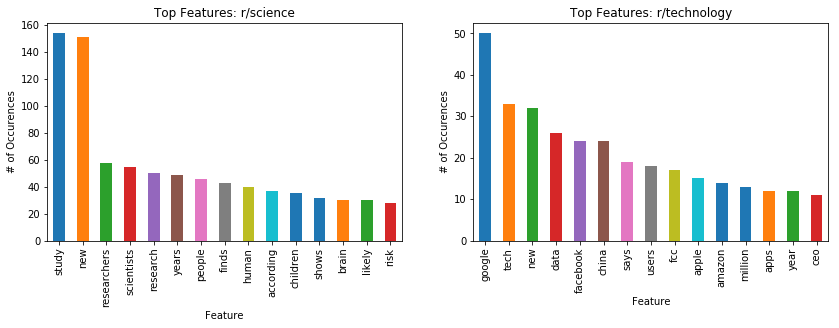

In [166]:
# Create subplots of most occuring words

plt.figure(figsize = (14,4))

plt.subplot(121)
top_feats_science.plot(kind='bar')
plt.title('Top Features: r/science')
plt.xlabel('Feature')
plt.ylabel('# of Occurences')

plt.subplot(122)
top_feats_technology.plot(kind='bar')
plt.title('Top Features: r/technology')
plt.xlabel('Feature')
plt.ylabel('# of Occurences');

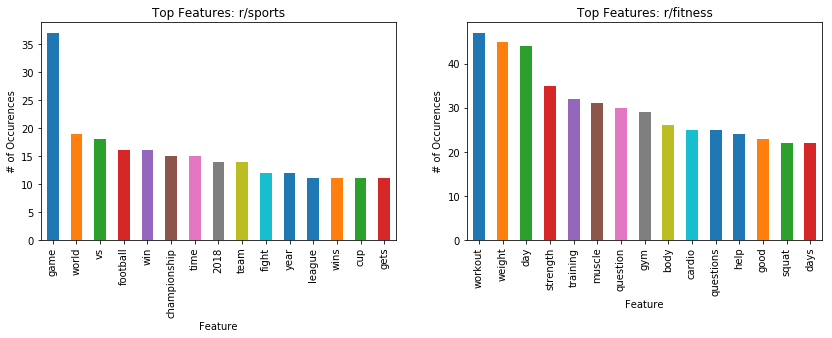

In [167]:
plt.figure(figsize = (14,4))

plt.subplot(121)
top_feats_sports.plot(kind='bar')
plt.title('Top Features: r/sports')
plt.xlabel('Feature')
plt.ylabel('# of Occurences')

plt.subplot(122)
top_feats_fitness.plot(kind='bar')
plt.title('Top Features: r/fitness')
plt.xlabel('Feature')
plt.ylabel('# of Occurences');